In [125]:
import requests
from bs4 import BeautifulSoup
def basic(inputID):
    authors = []
    base ="http://ieeexplore.ieee.org/xpl/articleDetails.jsp?arnumber="


    url = base + str(inputID)
    r = requests.get(url)
    soup = BeautifulSoup(r.content)

    try:
        title = soup.find('div', {'class': 'title'}).text.replace('\n', '').replace('\t', '')
    except:
        title = ''

    try:
        author = soup.find_all('span', {'id': 'preferredName'})
        tmp = []
        for item in author:
            tmp.append(str(item).replace('<span class="','').replace('" id="preferredName"></span>',''))
    except:
        author = ''
    authors.append('; '.join(list(set(tmp))))


    try:
        date = str(soup.find_all('dl')[1]).split('Date')[1].replace('\n','').replace('\t','').split('<dd>')[1].split('</dd>')[0]
    except:
        date = ''

    try:
        punumber = str(soup.find_all('a', {'href': re.compile('punumber')})[1]).split('number=')[1].split('">')[0]
    except:
        punumber = ''
        
    try:
        abstract = soup.find_all('div', {'class':'article'})[0].text.replace('\n', '').replace('\t', '')
    except:
        abstract = ''

    return {'title':title,
            'authors':authors,
            'date':date,
            'punumber':punumber,
            'abstract':abstract}

In [126]:
import requests
import re
import lxml
from lxml import html
from lxml import etree


def getArnumber(href):
        pattern = r"arnumber=\d*"
        match = re.search(pattern, href)
        if match:
                arnumber = match.group()[len("arnumber="):]
                arnumber = int(arnumber)
                return arnumber
        return None


def extractLine(line):
        links = line.find("div")
        if links != None:
                abstract = links.find("a")
                if abstract != None and abstract.text == "Abstract":
                        href = abstract.get("href")
                        return getArnumber(href)
        return None


""" References """
def getRefs(arnumber):
	site = "http://ieeexplore.ieee.org/xpl/abstractReferences.jsp?arnumber={0}".format(arnumber)
	page = requests.get(site)
	#print page.content
	try:
		tree = html.fromstring(page.content)
	except lxml.etree.ParseError:
		print "error: lxml.etree.ParseError"
		return []

	count = 0
	result = []
	refs = tree.xpath('//ol[@class = "docs"]')
	if len(refs) > 0:
		for ref in refs[0]:
			count += 1
			refNum = extractLine(ref)
			if refNum != None:
				result.append(refNum)	
	print "Number of references: ", count
	return {'count':count,
            'result':result}


""" Extended Version of Cited By """
def getCites(arnumber):
	site = "http://ieeexplore.ieee.org/xpl/abstractCitationsIeee.ajax?arnumber={0}".format(arnumber) 
	page = requests.get(site)
	#print page.content
	try:
		tree = html.fromstring(page.content)
	except lxml.etree.ParserError:
		print "error: lxml.etree.ParseError" 
		return []

	count = 0
	result = []
	for cite in tree.findall('li'):
		count += 1
		citeNum = extractLine(cite)
		if citeNum != None:
			result.append(citeNum)
	print "Number of cites: ", count
 	return {'count':count,
            'result':result}


""" Similar Articles """
def getSimls(arnumber):
	site = "http://ieeexplore.ieee.org/xpl/abstractSimilar.jsp?arnumber={0}".format(arnumber) 
	page = requests.get(site)
	try:
		tree = html.fromstring(page.content)
	except lxml.etree.ParserError:
		print "error: lxml.etree.ParseError"
		return []
	
	count = 0
	result = []
	pattern = r"arnumber=\d*"
	similars = tree.xpath('//ul[@class = "docs"]')
	if len(similars) > 0:
		for line in similars[0]:
			paper = line.find('h3/a')
			if paper != None and ('href' in paper.keys()):
				href = paper.get('href')
				simlNum = getArnumber(href)
				if simlNum != None:
					result.append(simlNum)
				count += 1
	print "Number of similars: ", count
	return result

		
def main():
	#arnumber = 4492369
	arnumber = 6995590
	getRefs(arnumber)
	getCites(arnumber)
	getSimls(arnumber)

In [127]:
#inputID = '726791'
inputID = '7037476'

In [128]:
basic(inputID)

{'abstract': u'We consider the fairness problem of outage probability balancing based on statistical channel state information (CSI) in closed-access femtocell networks where multiple subchannels are shared among macro and femto user equipments. We aim to maximize a utility function of outage probabilities for each femto user equipment (FUE) in the network under a macro user equipment (MUE) outage constraint. In light of rate requirement for each FUE, we jointly optimize the power allocation for both FUEs and MUEs as well as the rate allocation for FUE in each sub-channels. Using successive convex approximation, we develop a centralized algorithm to iteratively tackle a series of geometric programming problems. For base-stations connected through back-haul, we further design a distributed algorithm to update optimization variables locally through message passing.',
 'authors': ['Zhi Ding; Haining Wang'],
 'date': '',
 'punumber': '7008954',
 'title': u'Power control and rate allocation

In [129]:
a = getRefs(inputID)

Number of references:  12


In [130]:
type(a)

dict

In [131]:
def similarity(inputID):
    rootAbstract = basic(inputID)['abstract']
    seedIds = getRefs(inputID)['result']
    seedBasic = []
    seedImportance = []
    seedSimilarity = []
    
    for id in seedIds:
        seedBasic.append(basic(id))
        seedImportance.append(getCites(id)['count'])
        
    return {'rootAbstract':rootAbstract,
            'seedIds':seedIds,
            'seedBasic':seedBasic,
            'seedImportance':seedImportance}

In [132]:
b = similarity(inputID)

Number of references:  12
Number of cites:  21
Number of cites:  63
Number of cites:  39
Number of cites:  14
Number of cites:  15
Number of cites:  30
Number of cites:  243
Number of cites:  61
Number of cites:  14


In [133]:
b

{'rootAbstract': u'We consider the fairness problem of outage probability balancing based on statistical channel state information (CSI) in closed-access femtocell networks where multiple subchannels are shared among macro and femto user equipments. We aim to maximize a utility function of outage probabilities for each femto user equipment (FUE) in the network under a macro user equipment (MUE) outage constraint. In light of rate requirement for each FUE, we jointly optimize the power allocation for both FUEs and MUEs as well as the rate allocation for FUE in each sub-channels. Using successive convex approximation, we develop a centralized algorithm to iteratively tackle a series of geometric programming problems. For base-stations connected through back-haul, we further design a distributed algorithm to update optimization variables locally through message passing.',
 'seedBasic': [{'abstract': u'In a two tier cellular network comprised of a central macrocell underlaid with shorter r

In [134]:
seedYear = []
for item in b['seedBasic']:
    seedYear.append(item['date'])

In [135]:
seedYear

['',
 '',
 'February 2011',
 'Dec. 2011',
 'Dec. 2009',
 '',
 'Jan 2002',
 'Aug. 2009',
 'Tue Jan 24 00:00:00 EST 2012']

In [136]:
b['rootAbstract']

u'We consider the fairness problem of outage probability balancing based on statistical channel state information (CSI) in closed-access femtocell networks where multiple subchannels are shared among macro and femto user equipments. We aim to maximize a utility function of outage probabilities for each femto user equipment (FUE) in the network under a macro user equipment (MUE) outage constraint. In light of rate requirement for each FUE, we jointly optimize the power allocation for both FUEs and MUEs as well as the rate allocation for FUE in each sub-channels. Using successive convex approximation, we develop a centralized algorithm to iteratively tackle a series of geometric programming problems. For base-stations connected through back-haul, we further design a distributed algorithm to update optimization variables locally through message passing.'

In [137]:
b['seedBasic'][0]['abstract']

u'In a two tier cellular network comprised of a central macrocell underlaid with shorter range femtocell hotspots cross-tier interference limits overall capacity with universal frequency reuse. To quantify near-far effects, this paper derives a fundamental relation providing the largest feasible cellular signal-to-interference plus noise ratio (SINR), given any set of feasible femtocell SINRs. A distributed utility-based SINR adaptation at femtocells is proposed in order to alleviate cross-tier interference at the macrocell. The Foschini-Miljanic (FM) algorithm is a special case of the adaptation. Each femtocell maximizes their individual utility consisting of a SINR based reward less an incurred cost (cross-tier interference). Results show greater than 30% improvement in mean femtocell SINRs relative to FM. An algorithm is proposed that adaptively curtails transmission powers of the strongest femtocell interferers. Simulations show that a cell-edge user can achieve its SINR target eve

In [138]:
[b['rootAbstract'],b['seedBasic'][0]['abstract']]

[u'We consider the fairness problem of outage probability balancing based on statistical channel state information (CSI) in closed-access femtocell networks where multiple subchannels are shared among macro and femto user equipments. We aim to maximize a utility function of outage probabilities for each femto user equipment (FUE) in the network under a macro user equipment (MUE) outage constraint. In light of rate requirement for each FUE, we jointly optimize the power allocation for both FUEs and MUEs as well as the rate allocation for FUE in each sub-channels. Using successive convex approximation, we develop a centralized algorithm to iteratively tackle a series of geometric programming problems. For base-stations connected through back-haul, we further design a distributed algorithm to update optimization variables locally through message passing.',
 u'In a two tier cellular network comprised of a central macrocell underlaid with shorter range femtocell hotspots cross-tier interfer

In [139]:
from sklearn.feature_extraction.text import TfidfVectorizer
seedAbstract = [b['rootAbstract']]
for item in b['seedBasic']:
    seedAbstract.append(item['abstract'])
             
tfidf = TfidfVectorizer().fit_transform(seedAbstract)

In [140]:
pairwise_similarity = (tfidf * tfidf.T).A

In [141]:
seedAbstract

[u'We consider the fairness problem of outage probability balancing based on statistical channel state information (CSI) in closed-access femtocell networks where multiple subchannels are shared among macro and femto user equipments. We aim to maximize a utility function of outage probabilities for each femto user equipment (FUE) in the network under a macro user equipment (MUE) outage constraint. In light of rate requirement for each FUE, we jointly optimize the power allocation for both FUEs and MUEs as well as the rate allocation for FUE in each sub-channels. Using successive convex approximation, we develop a centralized algorithm to iteratively tackle a series of geometric programming problems. For base-stations connected through back-haul, we further design a distributed algorithm to update optimization variables locally through message passing.',
 u'In a two tier cellular network comprised of a central macrocell underlaid with shorter range femtocell hotspots cross-tier interfer

In [142]:
pairwise_similarity

array([[ 1.        ,  0.12467855,  0.24759744,  0.18923304,  0.22268184,
         0.32023647,  0.2962252 ,  0.3099162 ,  0.19338826,  0.28515932],
       [ 0.12467855,  1.        ,  0.27093586,  0.16155564,  0.32472497,
         0.18867204,  0.17257602,  0.1829468 ,  0.16276622,  0.1932972 ],
       [ 0.24759744,  0.27093586,  1.        ,  0.24897695,  0.48536605,
         0.35935251,  0.26897488,  0.3379371 ,  0.26163211,  0.32754328],
       [ 0.18923304,  0.16155564,  0.24897695,  1.        ,  0.27021677,
         0.23354233,  0.22175588,  0.37740233,  0.23200611,  0.26278172],
       [ 0.22268184,  0.32472497,  0.48536605,  0.27021677,  1.        ,
         0.39423203,  0.28240716,  0.34175737,  0.24267416,  0.34880111],
       [ 0.32023647,  0.18867204,  0.35935251,  0.23354233,  0.39423203,
         1.        ,  0.35370529,  0.35012402,  0.28630002,  0.31771103],
       [ 0.2962252 ,  0.17257602,  0.26897488,  0.22175588,  0.28240716,
         0.35370529,  1.        ,  0.41109956

In [143]:
pairwise_similarity = pairwise_similarity[0][1:]

In [144]:
import numpy as np
s1 = np.argsort(np.argsort(pairwise_similarity))

In [153]:
pairwise_similarity

array([ 0.12467855,  0.24759744,  0.18923304,  0.22268184,  0.32023647,
        0.2962252 ,  0.3099162 ,  0.19338826,  0.28515932])

In [145]:
s2 = np.argsort(np.argsort(b['seedImportance']))

In [152]:
b['seedImportance']

[21, 63, 39, 14, 15, 30, 243, 61, 14]

In [154]:
s1

array([0, 4, 1, 3, 8, 6, 7, 2, 5])

In [155]:
s2

array([3, 7, 5, 0, 2, 4, 8, 6, 1])

In [146]:
s1+s2

array([ 3, 11,  6,  3, 10, 10, 15,  8,  6])

In [147]:
pairwise_similarity

array([ 0.12467855,  0.24759744,  0.18923304,  0.22268184,  0.32023647,
        0.2962252 ,  0.3099162 ,  0.19338826,  0.28515932])

In [148]:
np.asarray(b['seedImportance'])

array([ 21,  63,  39,  14,  15,  30, 243,  61,  14])

In [149]:
s1+s2

array([ 3, 11,  6,  3, 10, 10, 15,  8,  6])

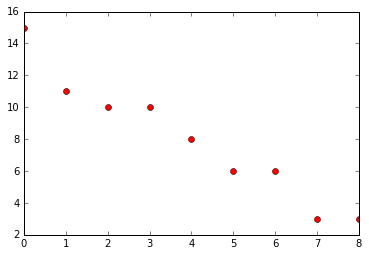

In [150]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(sorted(s1+s2, reverse=True), 'ro')

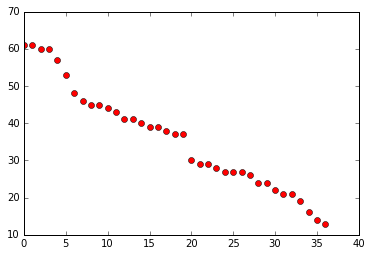

In [124]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(sorted(s1+s2, reverse=True), 'ro')

In [1]:
#! /usr/bin/env python
"""
This module provides classes for querying Google Scholar and parsing
returned results. It currently *only* processes the first results
page. It is not a recursive crawler.
"""
# ChangeLog
# ---------
#
# 2.10  Merged a fix for the "TypError: quote_from_bytes()" problem on
#       Python 3.x from hinnefe2.
#
# 2.9   Fixed Unicode problem in certain queries. Thanks to smidm for
#       this contribution.
#
# 2.8   Improved quotation-mark handling for multi-word phrases in
#       queries. Also, log URLs %-decoded in debugging output, for
#       easier interpretation.
#
# 2.7   Ability to extract content excerpts as reported in search results.
#       Also a fix to -s|--some and -n|--none: these did not yet support
#       passing lists of phrases. This now works correctly if you provide
#       separate phrases via commas.
#
# 2.6   Ability to disable inclusion of patents and citations. This
#       has the same effect as unchecking the two patents/citations
#       checkboxes in the Scholar UI, which are checked by default.
#       Accordingly, the command-line options are --no-patents and
#       --no-citations.
#
# 2.5:  Ability to parse global result attributes. This right now means
#       only the total number of results as reported by Scholar at the
#       top of the results pages (e.g. "About 31 results"). Such
#       global result attributes end up in the new attrs member of the
#       used ScholarQuery class. To render those attributes, you need
#       to use the new --txt-globals flag.
#
#       Rendering global results is currently not supported for CSV
#       (as they don't fit the one-line-per-article pattern). For
#       grepping, you can separate the global results from the
#       per-article ones by looking for a line prefix of "[G]":
#
#       $ scholar.py --txt-globals -a "Einstein"
#       [G]    Results 11900
#
#                Title Can quantum-mechanical description of physical reality be considered complete?
#                  URL http://journals.aps.org/pr/abstract/10.1103/PhysRev.47.777
#                 Year 1935
#            Citations 12804
#             Versions 80
#              Cluster ID 8174092782678430881
#       Citations list http://scholar.google.com/scholar?cites=8174092782678430881&as_sdt=2005&sciodt=0,5&hl=en
#        Versions list http://scholar.google.com/scholar?cluster=8174092782678430881&hl=en&as_sdt=0,5
#
# 2.4:  Bugfixes:
#
#       - Correctly handle Unicode characters when reporting results
#         in text format.
#
#       - Correctly parse citation-only (i.e. linkless) results in
#         Google Scholar results.
#
# 2.3:  Additional features:
#
#       - Direct extraction of first PDF version of an article
#
#       - Ability to pull up an article cluster's results directly.
#
#       This is based on work from @aliparsai on GitHub -- thanks!
#
#       - Suppress missing search results (so far shown as "None" in
#         the textual output form.
#
# 2.2:  Added a logging option that reports full HTML contents, for
#       debugging, as well as incrementally more detailed logging via
#       -d up to -dddd.
#
# 2.1:  Additional features:
#
#       - Improved cookie support: the new --cookie-file options
#         allows the reuse of a cookie across invocations of the tool;
#         this allows higher query rates than would otherwise result
#         when invoking scholar.py repeatedly.
#
#       - Workaround: remove the num= URL-encoded argument from parsed
#         URLs. For some reason, Google Scholar decides to propagate
#         the value from the original query into the URLs embedded in
#         the results.
#
# 2.0:  Thorough overhaul of design, with substantial improvements:
#
#       - Full support for advanced search arguments provided by
#         Google Scholar
#
#       - Support for retrieval of external citation formats, such as
#         BibTeX or EndNote
#
#       - Simple logging framework to track activity during execution
#
# 1.7:  Python 3 and BeautifulSoup 4 compatibility, as well as printing
#       of usage info when no options are given. Thanks to Pablo
#       Oliveira (https://github.com/pablooliveira)!
#
#       Also a bunch of pylinting and code cleanups.
#
# 1.6:  Cookie support, from Matej Smid (https://github.com/palmstrom).
#
# 1.5:  A few changes:
#
#       - Tweak suggested by Tobias Isenberg: use unicode during CSV
#         formatting.
#
#       - The option -c|--count now understands numbers up to 100 as
#         well. Likewise suggested by Tobias.
#
#       - By default, text rendering mode is now active. This avoids
#         confusion when playing with the script, as it used to report
#         nothing when the user didn't select an explicit output mode.
#
# 1.4:  Updates to reflect changes in Scholar's page rendering,
#       contributed by Amanda Hay at Tufts -- thanks!
#
# 1.3:  Updates to reflect changes in Scholar's page rendering.
#
# 1.2:  Minor tweaks, mostly thanks to helpful feedback from Dan Bolser.
#       Thanks Dan!
#
# 1.1:  Made author field explicit, added --author option.
#
# Don't complain about missing docstrings: pylint: disable-msg=C0111
#
# Copyright 2010--2014 Christian Kreibich. All rights reserved.
#
# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are
# met:
#
#    1. Redistributions of source code must retain the above copyright
#       notice, this list of conditions and the following disclaimer.
#
#    2. Redistributions in binary form must reproduce the above
#       copyright notice, this list of conditions and the following
#       disclaimer in the documentation and/or other materials provided
#       with the distribution.
#
# THIS SOFTWARE IS PROVIDED "AS IS" AND ANY EXPRESS OR IMPLIED
# WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF
# MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL THE AUTHORS BE LIABLE FOR ANY DIRECT,
# INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES
# (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
# SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION)
# HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT,
# STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING
# IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE
# POSSIBILITY OF SUCH DAMAGE.

import optparse
import os
import sys
import re

try:
    # Try importing for Python 3
    # pylint: disable-msg=F0401
    # pylint: disable-msg=E0611
    from urllib.request import HTTPCookieProcessor, Request, build_opener
    from urllib.parse import quote, unquote
    from http.cookiejar import MozillaCookieJar
except ImportError:
    # Fallback for Python 2
    from urllib2 import Request, build_opener, HTTPCookieProcessor
    from urllib import quote, unquote
    from cookielib import MozillaCookieJar

# Import BeautifulSoup -- try 4 first, fall back to older
try:
    from bs4 import BeautifulSoup
except ImportError:
    try:
        from BeautifulSoup import BeautifulSoup
    except ImportError:
        print('We need BeautifulSoup, sorry...')
        sys.exit(1)

# Support unicode in both Python 2 and 3. In Python 3, unicode is str.
if sys.version_info[0] == 3:
    unicode = str # pylint: disable-msg=W0622
    encode = lambda s: unicode(s) # pylint: disable-msg=C0103
else:
    def encode(s):
        if isinstance(s, basestring):
            return s.encode('utf-8') # pylint: disable-msg=C0103
        else:
            return str(s)


class Error(Exception):
    """Base class for any Scholar error."""


class FormatError(Error):
    """A query argument or setting was formatted incorrectly."""


class QueryArgumentError(Error):
    """A query did not have a suitable set of arguments."""


class ScholarConf(object):
    """Helper class for global settings."""

    VERSION = '2.10'
    LOG_LEVEL = 1
    MAX_PAGE_RESULTS = 20 # Current maximum for per-page results
    SCHOLAR_SITE = 'http://scholar.google.com'

    # USER_AGENT = 'Mozilla/5.0 (X11; U; FreeBSD i386; en-US; rv:1.9.2.9) Gecko/20100913 Firefox/3.6.9'
    # Let's update at this point (3/14):
    USER_AGENT = 'Mozilla/5.0 (X11; Linux x86_64; rv:27.0) Gecko/20100101 Firefox/27.0'

    # If set, we will use this file to read/save cookies to enable
    # cookie use across sessions.
    COOKIE_JAR_FILE = None

class ScholarUtils(object):
    """A wrapper for various utensils that come in handy."""

    LOG_LEVELS = {'error': 1,
                  'warn':  2,
                  'info':  3,
                  'debug': 4}

    @staticmethod
    def ensure_int(arg, msg=None):
        try:
            return int(arg)
        except ValueError:
            raise FormatError(msg)

    @staticmethod
    def log(level, msg):
        if level not in ScholarUtils.LOG_LEVELS.keys():
            return
        if ScholarUtils.LOG_LEVELS[level] > ScholarConf.LOG_LEVEL:
            return
        sys.stderr.write('[%5s]  %s' % (level.upper(), msg + '\n'))
        sys.stderr.flush()


class ScholarArticle(object):
    """
    A class representing articles listed on Google Scholar.  The class
    provides basic dictionary-like behavior.
    """
    def __init__(self):
        # The triplets for each keyword correspond to (1) the actual
        # value, (2) a user-suitable label for the item, and (3) an
        # ordering index:
        self.attrs = {
            'title':         [None, 'Title',          0],
            'url':           [None, 'URL',            1],
            'year':          [None, 'Year',           2],
            'num_citations': [0,    'Citations',      3],
            'num_versions':  [0,    'Versions',       4],
            'cluster_id':    [None, 'Cluster ID',     5],
            'url_pdf':       [None, 'PDF link',       6],
            'url_citations': [None, 'Citations list', 7],
            'url_versions':  [None, 'Versions list',  8],
            'url_citation':  [None, 'Citation link',  9],
            'excerpt':       [None, 'Excerpt',       10],
        }

        # The citation data in one of the standard export formats,
        # e.g. BibTeX.
        self.citation_data = None

    def __getitem__(self, key):
        if key in self.attrs:
            return self.attrs[key][0]
        return None

    def __len__(self):
        return len(self.attrs)

    def __setitem__(self, key, item):
        if key in self.attrs:
            self.attrs[key][0] = item
        else:
            self.attrs[key] = [item, key, len(self.attrs)]

    def __delitem__(self, key):
        if key in self.attrs:
            del self.attrs[key]

    def set_citation_data(self, citation_data):
        self.citation_data = citation_data

    def as_txt(self):
        # Get items sorted in specified order:
        items = sorted(list(self.attrs.values()), key=lambda item: item[2])
        # Find largest label length:
        max_label_len = max([len(str(item[1])) for item in items])
        fmt = '%%%ds %%s' % max_label_len
        res = []
        for item in items:
            if item[0] is not None:
                res.append(fmt % (item[1], item[0]))
        return '\n'.join(res)

    def as_csv(self, header=False, sep='|'):
        # Get keys sorted in specified order:
        keys = [pair[0] for pair in \
                sorted([(key, val[2]) for key, val in list(self.attrs.items())],
                       key=lambda pair: pair[1])]
        res = []
        if header:
            res.append(sep.join(keys))
        res.append(sep.join([unicode(self.attrs[key][0]) for key in keys]))
        return '\n'.join(res)

    def as_citation(self):
        """
        Reports the article in a standard citation format. This works only
        if you have configured the querier to retrieve a particular
        citation export format. (See ScholarSettings.)
        """
        return self.citation_data or ''


class ScholarArticleParser(object):
    """
    ScholarArticleParser can parse HTML document strings obtained from
    Google Scholar. This is a base class; concrete implementations
    adapting to tweaks made by Google over time follow below.
    """
    def __init__(self, site=None):
        self.soup = None
        self.article = None
        self.site = site or ScholarConf.SCHOLAR_SITE
        self.year_re = re.compile(r'\b(?:20|19)\d{2}\b')

    def handle_article(self, art):
        """
        The parser invokes this callback on each article parsed
        successfully.  In this base class, the callback does nothing.
        """

    def handle_num_results(self, num_results):
        """
        The parser invokes this callback if it determines the overall
        number of results, as reported on the parsed results page. The
        base class implementation does nothing.
        """

    def parse(self, html):
        """
        This method initiates parsing of HTML content, cleans resulting
        content as needed, and notifies the parser instance of
        resulting instances via the handle_article callback.
        """
        self.soup = BeautifulSoup(html)

        # This parses any global, non-itemized attributes from the page.
        self._parse_globals()

        # Now parse out listed articles:
        for div in self.soup.findAll(ScholarArticleParser._tag_results_checker):
            self._parse_article(div)
            self._clean_article()
            if self.article['title']:
                self.handle_article(self.article)

    def _clean_article(self):
        """
        This gets invoked after we have parsed an article, to do any
        needed cleanup/polishing before we hand off the resulting
        article.
        """
        if self.article['title']:
            self.article['title'] = self.article['title'].strip()

    def _parse_globals(self):
        tag = self.soup.find(name='div', attrs={'id': 'gs_ab_md'})
        if tag is not None:
            raw_text = tag.findAll(text=True)
            # raw text is a list because the body contains <b> etc
            if raw_text is not None and len(raw_text) > 0:
                try:
                    num_results = raw_text[0].split()[1]
                    # num_results may now contain commas to separate
                    # thousands, strip:
                    num_results = num_results.replace(',', '')
                    num_results = int(num_results)
                    self.handle_num_results(num_results)
                except (IndexError, ValueError):
                    pass

    def _parse_article(self, div):
        self.article = ScholarArticle()

        for tag in div:
            if not hasattr(tag, 'name'):
                continue

            if tag.name == 'div' and self._tag_has_class(tag, 'gs_rt') and \
                    tag.h3 and tag.h3.a:
                self.article['title'] = ''.join(tag.h3.a.findAll(text=True))
                self.article['url'] = self._path2url(tag.h3.a['href'])
                if self.article['url'].endswith('.pdf'):
                    self.article['url_pdf'] = self.article['url']

            if tag.name == 'font':
                for tag2 in tag:
                    if not hasattr(tag2, 'name'):
                        continue
                    if tag2.name == 'span' and \
                       self._tag_has_class(tag2, 'gs_fl'):
                        self._parse_links(tag2)

    def _parse_links(self, span):
        for tag in span:
            if not hasattr(tag, 'name'):
                continue
            if tag.name != 'a' or tag.get('href') is None:
                continue

            if tag.get('href').startswith('/scholar?cites'):
                if hasattr(tag, 'string') and tag.string.startswith('Cited by'):
                    self.article['num_citations'] = \
                        self._as_int(tag.string.split()[-1])

                # Weird Google Scholar behavior here: if the original
                # search query came with a number-of-results limit,
                # then this limit gets propagated to the URLs embedded
                # in the results page as well. Same applies to
                # versions URL in next if-block.
                self.article['url_citations'] = \
                    self._strip_url_arg('num', self._path2url(tag.get('href')))

                # We can also extract the cluster ID from the versions
                # URL. Note that we know that the string contains "?",
                # from the above if-statement.
                args = self.article['url_citations'].split('?', 1)[1]
                for arg in args.split('&'):
                    if arg.startswith('cites='):
                        self.article['cluster_id'] = arg[6:]

            if tag.get('href').startswith('/scholar?cluster'):
                if hasattr(tag, 'string') and tag.string.startswith('All '):
                    self.article['num_versions'] = \
                        self._as_int(tag.string.split()[1])
                self.article['url_versions'] = \
                    self._strip_url_arg('num', self._path2url(tag.get('href')))

            if tag.getText().startswith('Import'):
                self.article['url_citation'] = self._path2url(tag.get('href'))


    @staticmethod
    def _tag_has_class(tag, klass):
        """
        This predicate function checks whether a BeatifulSoup Tag instance
        has a class attribute.
        """
        res = tag.get('class') or []
        if type(res) != list:
            # BeautifulSoup 3 can return e.g. 'gs_md_wp gs_ttss',
            # so split -- conveniently produces a list in any case
            res = res.split()
        return klass in res

    @staticmethod
    def _tag_results_checker(tag):
        return tag.name == 'div' \
            and ScholarArticleParser._tag_has_class(tag, 'gs_r')

    @staticmethod
    def _as_int(obj):
        try:
            return int(obj)
        except ValueError:
            return None

    def _path2url(self, path):
        """Helper, returns full URL in case path isn't one."""
        if path.startswith('http://'):
            return path
        if not path.startswith('/'):
            path = '/' + path
        return self.site + path

    def _strip_url_arg(self, arg, url):
        """Helper, removes a URL-encoded argument, if present."""
        parts = url.split('?', 1)
        if len(parts) != 2:
            return url
        res = []
        for part in parts[1].split('&'):
            if not part.startswith(arg + '='):
                res.append(part)
        return parts[0] + '?' + '&'.join(res)


class ScholarArticleParser120201(ScholarArticleParser):
    """
    This class reflects update to the Scholar results page layout that
    Google recently.
    """
    def _parse_article(self, div):
        self.article = ScholarArticle()

        for tag in div:
            if not hasattr(tag, 'name'):
                continue

            if tag.name == 'h3' and self._tag_has_class(tag, 'gs_rt') and tag.a:
                self.article['title'] = ''.join(tag.a.findAll(text=True))
                self.article['url'] = self._path2url(tag.a['href'])
                if self.article['url'].endswith('.pdf'):
                    self.article['url_pdf'] = self.article['url']

            if tag.name == 'div' and self._tag_has_class(tag, 'gs_a'):
                year = self.year_re.findall(tag.text)
                self.article['year'] = year[0] if len(year) > 0 else None

            if tag.name == 'div' and self._tag_has_class(tag, 'gs_fl'):
                self._parse_links(tag)


class ScholarArticleParser120726(ScholarArticleParser):
    """
    This class reflects update to the Scholar results page layout that
    Google made 07/26/12.
    """
    def _parse_article(self, div):
        self.article = ScholarArticle()

        for tag in div:
            if not hasattr(tag, 'name'):
                continue
            if str(tag).lower().find('.pdf'):
                if tag.find('div', {'class': 'gs_ttss'}):
                    self._parse_links(tag.find('div', {'class': 'gs_ttss'}))

            if tag.name == 'div' and self._tag_has_class(tag, 'gs_ri'):
                # There are (at least) two formats here. In the first
                # one, we have a link, e.g.:
                #
                # <h3 class="gs_rt">
                #   <a href="http://dl.acm.org/citation.cfm?id=972384" class="yC0">
                #     <b>Honeycomb</b>: creating intrusion detection signatures using
                #        honeypots
                #   </a>
                # </h3>
                #
                # In the other, there's no actual link -- it's what
                # Scholar renders as "CITATION" in the HTML:
                #
                # <h3 class="gs_rt">
                #   <span class="gs_ctu">
                #     <span class="gs_ct1">[CITATION]</span>
                #     <span class="gs_ct2">[C]</span>
                #   </span>
                #   <b>Honeycomb</b> automated ids signature creation using honeypots
                # </h3>
                #
                # We now distinguish the two.
                try:
                    atag = tag.h3.a
                    self.article['title'] = ''.join(atag.findAll(text=True))
                    self.article['url'] = self._path2url(atag['href'])
                    if self.article['url'].endswith('.pdf'):
                        self.article['url_pdf'] = self.article['url']
                except:
                    # Remove a few spans that have unneeded content (e.g. [CITATION])
                    for span in tag.h3.findAll(name='span'):
                        span.clear()
                    self.article['title'] = ''.join(tag.h3.findAll(text=True))

                if tag.find('div', {'class': 'gs_a'}):
                    year = self.year_re.findall(tag.find('div', {'class': 'gs_a'}).text)
                    self.article['year'] = year[0] if len(year) > 0 else None

                if tag.find('div', {'class': 'gs_fl'}):
                    self._parse_links(tag.find('div', {'class': 'gs_fl'}))

                if tag.find('div', {'class': 'gs_rs'}):
                    # These are the content excerpts rendered into the results.
                    raw_text = tag.find('div', {'class': 'gs_rs'}).findAll(text=True)
                    if len(raw_text) > 0:
                        raw_text = ''.join(raw_text)
                        raw_text = raw_text.replace('\n', '')
                        self.article['excerpt'] = raw_text


class ScholarQuery(object):
    """
    The base class for any kind of results query we send to Scholar.
    """
    def __init__(self):
        self.url = None

        # The number of results requested from Scholar -- not the
        # total number of results it reports (the latter gets stored
        # in attrs, see below).
        self.num_results = ScholarConf.MAX_PAGE_RESULTS

        # Queries may have global result attributes, similar to
        # per-article attributes in ScholarArticle. The exact set of
        # attributes may differ by query type, but they all share the
        # basic data structure:
        self.attrs = {}

    def set_num_page_results(self, num_page_results):
        msg = 'maximum number of results on page must be numeric'
        self.num_results = ScholarUtils.ensure_int(num_page_results, msg)

    def get_url(self):
        """
        Returns a complete, submittable URL string for this particular
        query instance. The URL and its arguments will vary depending
        on the query.
        """
        return None

    def _add_attribute_type(self, key, label, default_value=None):
        """
        Adds a new type of attribute to the list of attributes
        understood by this query. Meant to be used by the constructors
        in derived classes.
        """
        if len(self.attrs) == 0:
            self.attrs[key] = [default_value, label, 0]
            return
        idx = max([item[2] for item in self.attrs.values()]) + 1
        self.attrs[key] = [default_value, label, idx]

    def __getitem__(self, key):
        """Getter for attribute value. Returns None if no such key."""
        if key in self.attrs:
            return self.attrs[key][0]
        return None

    def __setitem__(self, key, item):
        """Setter for attribute value. Does nothing if no such key."""
        if key in self.attrs:
            self.attrs[key][0] = item

    def _parenthesize_phrases(self, query):
        """
        Turns a query string containing comma-separated phrases into a
        space-separated list of tokens, quoted if containing
        whitespace. For example, input

          'some words, foo, bar'

        becomes

          '"some words" foo bar'

        This comes in handy during the composition of certain queries.
        """
        if query.find(',') < 0:
            return query
        phrases = []
        for phrase in query.split(','):
            phrase = phrase.strip()
            if phrase.find(' ') > 0:
                phrase = '"' + phrase + '"'
            phrases.append(phrase)
        return ' '.join(phrases)


class ClusterScholarQuery(ScholarQuery):
    """
    This version just pulls up an article cluster whose ID we already
    know about.
    """
    SCHOLAR_CLUSTER_URL = ScholarConf.SCHOLAR_SITE + '/scholar?' \
        + 'cluster=%(cluster)s' \
        + '&num=%(num)s'

    def __init__(self, cluster=None):
        ScholarQuery.__init__(self)
        self._add_attribute_type('num_results', 'Results', 0)
        self.cluster = None
        self.set_cluster(cluster)

    def set_cluster(self, cluster):
        """
        Sets search to a Google Scholar results cluster ID.
        """
        msg = 'cluster ID must be numeric'
        self.cluster = ScholarUtils.ensure_int(cluster, msg)

    def get_url(self):
        if self.cluster is None:
            raise QueryArgumentError('cluster query needs cluster ID')

        urlargs = {'cluster': self.cluster,
                   'num': self.num_results or ScholarConf.MAX_PAGE_RESULTS}

        for key, val in urlargs.items():
            urlargs[key] = quote(encode(val))

        return self.SCHOLAR_CLUSTER_URL % urlargs


class SearchScholarQuery(ScholarQuery):
    """
    This version represents the search query parameters the user can
    configure on the Scholar website, in the advanced search options.
    """
    SCHOLAR_QUERY_URL = ScholarConf.SCHOLAR_SITE + '/scholar?' \
        + 'as_q=%(words)s' \
        + '&as_epq=%(phrase)s' \
        + '&as_oq=%(words_some)s' \
        + '&as_eq=%(words_none)s' \
        + '&as_occt=%(scope)s' \
        + '&as_sauthors=%(authors)s' \
        + '&as_publication=%(pub)s' \
        + '&as_ylo=%(ylo)s' \
        + '&as_yhi=%(yhi)s' \
        + '&as_sdt=%(patents)s%%2C5' \
        + '&as_vis=%(citations)s' \
        + '&btnG=&hl=en' \
        + '&num=%(num)s'

    def __init__(self):
        ScholarQuery.__init__(self)
        self._add_attribute_type('num_results', 'Results', 0)
        self.words = None # The default search behavior
        self.words_some = None # At least one of those words
        self.words_none = None # None of these words
        self.phrase = None
        self.scope_title = False # If True, search in title only
        self.author = None 
        self.pub = None
        self.timeframe = [None, None]
        self.include_patents = True
        self.include_citations = True

    def set_words(self, words):
        """Sets words that *all* must be found in the result."""
        self.words = words

    def set_words_some(self, words):
        """Sets words of which *at least one* must be found in result."""
        self.words_some = words

    def set_words_none(self, words):
        """Sets words of which *none* must be found in the result."""
        self.words_none = words

    def set_phrase(self, phrase):
        """Sets phrase that must be found in the result exactly."""
        self.phrase = phrase

    def set_scope(self, title_only):
        """
        Sets Boolean indicating whether to search entire article or title
        only.
        """
        self.scope_title = title_only

    def set_author(self, author):
        """Sets names that must be on the result's author list."""
        self.author = author

    def set_pub(self, pub):
        """Sets the publication in which the result must be found."""
        self.pub = pub

    def set_timeframe(self, start=None, end=None):
        """
        Sets timeframe (in years as integer) in which result must have
        appeared. It's fine to specify just start or end, or both.
        """
        if start:
            start = ScholarUtils.ensure_int(start)
        if end:
            end = ScholarUtils.ensure_int(end)
        self.timeframe = [start, end]

    def set_include_citations(self, yesorno):
        self.include_citations = yesorno

    def set_include_patents(self, yesorno):
        self.include_patents = yesorno

    def get_url(self):
        if self.words is None and self.words_some is None \
           and self.words_none is None and self.phrase is None \
           and self.author is None and self.pub is None \
           and self.timeframe[0] is None and self.timeframe[1] is None:
            raise QueryArgumentError('search query needs more parameters')

        # If we have some-words or none-words lists, we need to
        # process them so GS understands them. For simple
        # space-separeted word lists, there's nothing to do. For lists
        # of phrases we have to ensure quotations around the phrases,
        # separating them by whitespace.
        words_some = None
        words_none = None

        if self.words_some:
            words_some = self._parenthesize_phrases(self.words_some)
        if self.words_none:
            words_none = self._parenthesize_phrases(self.words_none)

        urlargs = {'words': self.words or '',
                   'words_some': words_some or '',
                   'words_none': words_none or '',
                   'phrase': self.phrase or '',
                   'scope': 'title' if self.scope_title else 'any',
                   'authors': self.author or '',
                   'pub': self.pub or '',
                   'ylo': self.timeframe[0] or '',
                   'yhi': self.timeframe[1] or '',
                   'patents': '0' if self.include_patents else '1',
                   'citations': '0' if self.include_citations else '1',
                   'num': self.num_results or ScholarConf.MAX_PAGE_RESULTS}

        for key, val in urlargs.items():
            urlargs[key] = quote(encode(val))

        return self.SCHOLAR_QUERY_URL % urlargs


class ScholarSettings(object):

    """
    This class lets you adjust the Scholar settings for your
    session. It's intended to mirror the features tunable in the
    Scholar Settings pane, but right now it's a bit basic.
    """
    CITFORM_NONE = 0
    CITFORM_REFWORKS = 1
    CITFORM_REFMAN = 2
    CITFORM_ENDNOTE = 3
    CITFORM_BIBTEX = 4

    def __init__(self):
        self.citform = 0 # Citation format, default none
        self.per_page_results = ScholarConf.MAX_PAGE_RESULTS
        self._is_configured = False

    def set_citation_format(self, citform):
        citform = ScholarUtils.ensure_int(citform)
        if citform < 0 or citform > self.CITFORM_BIBTEX:
            raise FormatError('citation format invalid, is "%s"' \
                              % citform)
        self.citform = citform
        self._is_configured = True

    def set_per_page_results(self, per_page_results):
        msg = 'page results must be integer'
        self.per_page_results = ScholarUtils.ensure_int(per_page_results, msg)
        self.per_page_results = min(self.per_page_results,
                                    ScholarConf.MAX_PAGE_RESULTS)
        self._is_configured = True

    def is_configured(self):
        return self._is_configured


class ScholarQuerier(object):

    """
    ScholarQuerier instances can conduct a search on Google Scholar
    with subsequent parsing of the resulting HTML content.  The
    articles found are collected in the articles member, a list of
    ScholarArticle instances.
    """

    # Default URLs for visiting and submitting Settings pane, as of 3/14
    GET_SETTINGS_URL = ScholarConf.SCHOLAR_SITE + '/scholar_settings?' \
        + 'sciifh=1&hl=en&as_sdt=0,5'

    SET_SETTINGS_URL = ScholarConf.SCHOLAR_SITE + '/scholar_setprefs?' \
        + 'q=' \
        + '&scisig=%(scisig)s' \
        + '&inststart=0' \
        + '&as_sdt=1,5' \
        + '&as_sdtp=' \
        + '&num=%(num)s' \
        + '&scis=%(scis)s' \
        + '%(scisf)s' \
        + '&hl=en&lang=all&instq=&inst=569367360547434339&save='

    # Older URLs:
    # ScholarConf.SCHOLAR_SITE + '/scholar?q=%s&hl=en&btnG=Search&as_sdt=2001&as_sdtp=on

    class Parser(ScholarArticleParser120726):
        def __init__(self, querier):
            ScholarArticleParser120726.__init__(self)
            self.querier = querier

        def handle_num_results(self, num_results):
            if self.querier is not None and self.querier.query is not None:
                self.querier.query['num_results'] = num_results

        def handle_article(self, art):
            self.querier.add_article(art)

    def __init__(self):
        self.articles = []
        self.query = None
        self.cjar = MozillaCookieJar()

        # If we have a cookie file, load it:
        if ScholarConf.COOKIE_JAR_FILE and \
           os.path.exists(ScholarConf.COOKIE_JAR_FILE):
            try:
                self.cjar.load(ScholarConf.COOKIE_JAR_FILE,
                               ignore_discard=True)
                ScholarUtils.log('info', 'loaded cookies file')
            except Exception as msg:
                ScholarUtils.log('warn', 'could not load cookies file: %s' % msg)
                self.cjar = MozillaCookieJar() # Just to be safe

        self.opener = build_opener(HTTPCookieProcessor(self.cjar))
        self.settings = None # Last settings object, if any

    def apply_settings(self, settings):
        """
        Applies settings as provided by a ScholarSettings instance.
        """
        if settings is None or not settings.is_configured():
            return True

        self.settings = settings

        # This is a bit of work. We need to actually retrieve the
        # contents of the Settings pane HTML in order to extract
        # hidden fields before we can compose the query for updating
        # the settings.
        html = self._get_http_response(url=self.GET_SETTINGS_URL,
                                       log_msg='dump of settings form HTML',
                                       err_msg='requesting settings failed')
        if html is None:
            return False

        # Now parse the required stuff out of the form. We require the
        # "scisig" token to make the upload of our settings acceptable
        # to Google.
        soup = BeautifulSoup(html)

        tag = soup.find(name='form', attrs={'id': 'gs_settings_form'})
        if tag is None:
            ScholarUtils.log('info', 'parsing settings failed: no form')
            return False

        tag = tag.find('input', attrs={'type':'hidden', 'name':'scisig'})
        if tag is None:
            ScholarUtils.log('info', 'parsing settings failed: scisig')
            return False

        urlargs = {'scisig': tag['value'],
                   'num': settings.per_page_results,
                   'scis': 'no',
                   'scisf': ''}

        if settings.citform != 0:
            urlargs['scis'] = 'yes'
            urlargs['scisf'] = '&scisf=%d' % settings.citform

        html = self._get_http_response(url=self.SET_SETTINGS_URL % urlargs,
                                       log_msg='dump of settings result HTML',
                                       err_msg='applying setttings failed')
        if html is None:
            return False

        ScholarUtils.log('info', 'settings applied')
        return True

    def send_query(self, query):
        """
        This method initiates a search query (a ScholarQuery instance)
        with subsequent parsing of the response.
        """
        self.clear_articles()
        self.query = query

        html = self._get_http_response(url=query.get_url(),
                                       log_msg='dump of query response HTML',
                                       err_msg='results retrieval failed')
        if html is None:
            return

        self.parse(html)

    def get_citation_data(self, article):
        """
        Given an article, retrieves citation link. Note, this requires that
        you adjusted the settings to tell Google Scholar to actually
        provide this information, *prior* to retrieving the article.
        """
        if article['url_citation'] is None:
            return False
        if article.citation_data is not None:
            return True

        ScholarUtils.log('info', 'retrieving citation export data')
        data = self._get_http_response(url=article['url_citation'],
                                       log_msg='citation data response',
                                       err_msg='requesting citation data failed')
        if data is None:
            return False

        article.set_citation_data(data)
        return True

    def parse(self, html):
        """
        This method allows parsing of provided HTML content.
        """
        parser = self.Parser(self)
        parser.parse(html)

    def add_article(self, art):
        self.get_citation_data(art)
        self.articles.append(art)

    def clear_articles(self):
        """Clears any existing articles stored from previous queries."""
        self.articles = []

    def save_cookies(self):
        """
        This stores the latest cookies we're using to disk, for reuse in a
        later session.
        """
        if ScholarConf.COOKIE_JAR_FILE is None:
            return False
        try:
            self.cjar.save(ScholarConf.COOKIE_JAR_FILE,
                           ignore_discard=True)
            ScholarUtils.log('info', 'saved cookies file')
            return True
        except Exception as msg:
            ScholarUtils.log('warn', 'could not save cookies file: %s' % msg)
            return False

    def _get_http_response(self, url, log_msg=None, err_msg=None):
        """
        Helper method, sends HTTP request and returns response payload.
        """
        if log_msg is None:
            log_msg = 'HTTP response data follow'
        if err_msg is None:
            err_msg = 'request failed'
        try:
            ScholarUtils.log('info', 'requesting %s' % unquote(url))

            req = Request(url=url, headers={'User-Agent': ScholarConf.USER_AGENT})
            hdl = self.opener.open(req)
            html = hdl.read()

            ScholarUtils.log('debug', log_msg)
            ScholarUtils.log('debug', '>>>>' + '-'*68)
            ScholarUtils.log('debug', 'url: %s' % hdl.geturl())
            ScholarUtils.log('debug', 'result: %s' % hdl.getcode())
            ScholarUtils.log('debug', 'headers:\n' + str(hdl.info()))
            ScholarUtils.log('debug', 'data:\n' + html.decode('utf-8')) # For Python 3
            ScholarUtils.log('debug', '<<<<' + '-'*68)

            return html
        except Exception as err:
            ScholarUtils.log('info', err_msg + ': %s' % err)
            return None


def txt(querier, with_globals):
    if with_globals:
        # If we have any articles, check their attribute labels to get
        # the maximum length -- makes for nicer alignment.
        max_label_len = 0
        if len(querier.articles) > 0:
            items = sorted(list(querier.articles[0].attrs.values()),
                           key=lambda item: item[2])
            max_label_len = max([len(str(item[1])) for item in items])

        # Get items sorted in specified order:
        items = sorted(list(querier.query.attrs.values()), key=lambda item: item[2])
        # Find largest label length:
        max_label_len = max([len(str(item[1])) for item in items] + [max_label_len])
        fmt = '[G] %%%ds %%s' % max(0, max_label_len-4)
        for item in items:
            if item[0] is not None:
                print(fmt % (item[1], item[0]))
        if len(items) > 0:
            print

    articles = querier.articles
    for art in articles:
        print(encode(art.as_txt()) + '\n')

def csv(querier, header=False, sep='|'):
    articles = querier.articles
    for art in articles:
        result = art.as_csv(header=header, sep=sep)
        print(encode(result))
        header = False

def citation_export(querier):
    articles = querier.articles
    for art in articles:
        print(art.as_citation() + '\n')


def main():
    usage = """scholar.py [options] <query string>
A command-line interface to Google Scholar.

Examples:

# Retrieve one article written by Einstein on quantum theory:
scholar.py -c 1 --author "albert einstein" --phrase "quantum theory"

# Retrieve a BibTeX entry for that quantum theory paper:
scholar.py -c 1 -C 17749203648027613321 --citation bt

# Retrieve five articles written by Einstein after 1970 where the title
# does not contain the words "quantum" and "theory":
scholar.py -c 5 -a "albert einstein" -t --none "quantum theory" --after 1970"""

    fmt = optparse.IndentedHelpFormatter(max_help_position=50, width=100)
    parser = optparse.OptionParser(usage=usage, formatter=fmt)
    group = optparse.OptionGroup(parser, 'Query arguments',
                                 'These options define search query arguments and parameters.')
    group.add_option('-a', '--author', metavar='AUTHORS', default=None,
                     help='Author name(s)')
    group.add_option('-A', '--all', metavar='WORDS', default=None, dest='allw',
                     help='Results must contain all of these words')
    group.add_option('-s', '--some', metavar='WORDS', default=None,
                     help='Results must contain at least one of these words. Pass arguments in form -s "foo bar baz" for simple words, and -s "a phrase, another phrase" for phrases')
    group.add_option('-n', '--none', metavar='WORDS', default=None,
                     help='Results must contain none of these words. See -s|--some re. formatting')
    group.add_option('-p', '--phrase', metavar='PHRASE', default=None,
                     help='Results must contain exact phrase')
    group.add_option('-t', '--title-only', action='store_true', default=False,
                     help='Search title only')
    group.add_option('-P', '--pub', metavar='PUBLICATIONS', default=None,
                     help='Results must have appeared in this publication')
    group.add_option('--after', metavar='YEAR', default=None,
                     help='Results must have appeared in or after given year')
    group.add_option('--before', metavar='YEAR', default=None,
                     help='Results must have appeared in or before given year')
    group.add_option('--no-patents', action='store_true', default=False,
                     help='Do not include patents in results')
    group.add_option('--no-citations', action='store_true', default=False,
                     help='Do not include citations in results')
    group.add_option('-C', '--cluster-id', metavar='CLUSTER_ID', default=None,
                     help='Do not search, just use articles in given cluster ID')
    group.add_option('-c', '--count', type='int', default=None,
                     help='Maximum number of results')
    parser.add_option_group(group)

    group = optparse.OptionGroup(parser, 'Output format',
                                 'These options control the appearance of the results.')
    group.add_option('--txt', action='store_true',
                     help='Print article data in text format (default)')
    group.add_option('--txt-globals', action='store_true',
                     help='Like --txt, but first print global results too')
    group.add_option('--csv', action='store_true',
                     help='Print article data in CSV form (separator is "|")')
    group.add_option('--csv-header', action='store_true',
                     help='Like --csv, but print header with column names')
    group.add_option('--citation', metavar='FORMAT', default=None,
                     help='Print article details in standard citation format. Argument Must be one of "bt" (BibTeX), "en" (EndNote), "rm" (RefMan), or "rw" (RefWorks).')
    parser.add_option_group(group)

    group = optparse.OptionGroup(parser, 'Miscellaneous')
    group.add_option('--cookie-file', metavar='FILE', default=None,
                     help='File to use for cookie storage. If given, will read any existing cookies if found at startup, and save resulting cookies in the end.')
    group.add_option('-d', '--debug', action='count', default=0,
                     help='Enable verbose logging to stderr. Repeated options increase detail of debug output.')
    group.add_option('-v', '--version', action='store_true', default=False,
                     help='Show version information')
    parser.add_option_group(group)

    options, _ = parser.parse_args()

    # Show help if we have neither keyword search nor author name
    if len(sys.argv) == 1:
        parser.print_help()
        return 1

    if options.debug > 0:
        options.debug = min(options.debug, ScholarUtils.LOG_LEVELS['debug'])
        ScholarConf.LOG_LEVEL = options.debug
        ScholarUtils.log('info', 'using log level %d' % ScholarConf.LOG_LEVEL)

    if options.version:
        print('This is scholar.py %s.' % ScholarConf.VERSION)
        return 0

    if options.cookie_file:
        ScholarConf.COOKIE_JAR_FILE = options.cookie_file

    # Sanity-check the options: if they include a cluster ID query, it
    # makes no sense to have search arguments:
    if options.cluster_id is not None:
        if options.author or options.allw or options.some or options.none \
           or options.phrase or options.title_only or options.pub \
           or options.after or options.before:
            print('Cluster ID queries do not allow additional search arguments.')
            return 1

    querier = ScholarQuerier()
    settings = ScholarSettings()

    if options.citation == 'bt':
        settings.set_citation_format(ScholarSettings.CITFORM_BIBTEX)
    elif options.citation == 'en':
        settings.set_citation_format(ScholarSettings.CITFORM_ENDNOTE)
    elif options.citation == 'rm':
        settings.set_citation_format(ScholarSettings.CITFORM_REFMAN)
    elif options.citation == 'rw':
        settings.set_citation_format(ScholarSettings.CITFORM_REFWORKS)
    elif options.citation is not None:
        print('Invalid citation link format, must be one of "bt", "en", "rm", or "rw".')
        return 1

    querier.apply_settings(settings)

    if options.cluster_id:
        query = ClusterScholarQuery(cluster=options.cluster_id)
    else:
        query = SearchScholarQuery()
        if options.author:
            query.set_author(options.author)
        if options.allw:
            query.set_words(options.allw)
        if options.some:
            query.set_words_some(options.some)
        if options.none:
            query.set_words_none(options.none)
        if options.phrase:
            query.set_phrase(options.phrase)
        if options.title_only:
            query.set_scope(True)
        if options.pub:
            query.set_pub(options.pub)
        if options.after or options.before:
            query.set_timeframe(options.after, options.before)
        if options.no_patents:
            query.set_include_patents(False)
        if options.no_citations:
            query.set_include_citations(False)

    if options.count is not None:
        options.count = min(options.count, ScholarConf.MAX_PAGE_RESULTS)
        query.set_num_page_results(options.count)

    querier.send_query(query)

    if options.csv:
        csv(querier)
    elif options.csv_header:
        csv(querier, header=True)
    elif options.citation is not None:
        citation_export(querier)
    else:
        txt(querier, with_globals=options.txt_globals)

    if options.cookie_file:
        querier.save_cookies()

    return 0

if __name__ == "__main__":
    sys.exit(main())


Usage: scholar.py [options] <query string>
A command-line interface to Google Scholar.

Examples:

# Retrieve one article written by Einstein on quantum theory:
scholar.py -c 1 --author "albert einstein" --phrase "quantum theory"

# Retrieve a BibTeX entry for that quantum theory paper:
scholar.py -c 1 -C 17749203648027613321 --citation bt

# Retrieve five articles written by Einstein after 1970 where the title
# does not contain the words "quantum" and "theory":
scholar.py -c 5 -a "albert einstein" -t --none "quantum theory" --after 1970

__main__.py: error: no such option: -f


SystemExit: 2

To exit: use 'exit', 'quit', or Ctrl-D.
